# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from scipy.stats import norm

In [5]:
data = pd.io.stata.read_stata('data_racial_discrimination/us_job_market_discrimination.dta')

In [6]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [7]:
data.head()

id ad  education  ofjobs  yearsexp  honors  volunteer  military  empholes  \
0  b  1          4       2         6       0          0         0         1   
1  b  1          3       3         6       0          1         1         0   
2  b  1          4       1         6       0          0         0         0   
3  b  1          3       4         6       0          1         0         1   
4  b  1          3       3        22       0          0         0         0   

   occupspecific    ...      compreq  orgreq  manuf  transcom  bankreal trade  \
0             17    ...          1.0     0.0    1.0       0.0       0.0   0.0   
1            316    ...          1.0     0.0    1.0       0.0       0.0   0.0   
2             19    ...          1.0     0.0    1.0       0.0       0.0   0.0   
3            313    ...          1.0     0.0    1.0       0.0       0.0   0.0   
4            313    ...          1.0     1.0    0.0       0.0       0.0   0.0   

  busservice othservice  missind  ownership  
0        0.0        0.0      0.0             
1        0.0        0.0      0.0             
2        0.0        0.0      0.0             
3        0.0        0.0      0.0             
4        0.0        1.0      0.0  Nonprofit  

[5 rows x 65 columns]

## 1. What test is appropriate for this problem? Does CLT apply?

In [122]:
w = data.loc[data.race=='w', 'call'].astype('category') # extract call column for white-sounding names and convert to categorical data
b = data.loc[data.race=='b', 'call'].astype('category') # extract call column for black-sounding names and convert to categorical data

w_counts_table = w.value_counts().reset_index()
b_counts_table = b.value_counts().reset_index()

n_w = len(w) # calculate sample size for white-sounding names
n_b = len(b) # calculate sample size for black-sounding names
p_w = w_counts_table.iloc[1, 1]/n_w # calculate sample proportion for white return calls
p_b = b_counts_table.iloc[1,1]/n_b  # calculate sample proportion for black return calls


# check normality condition for white-sounding names
print('normality test for white-sounding names: np = {}, n(1 - p) = {}'.format(n_w * p_w, n_w * (1 - p_w)))

# check normality condition for black-sounding names
print('normality test for black-sounding names: np = {}, n(1 - p) = {}'.format(n_b * p_b, n_b * (1 - p_b)))

normality test for whites: np = 235.0, n(1 - p) = 2200.0
normality test for blacks: np = 157.0, n(1 - p) = 2278.0


The bootstrap test of proportions applies here. For the frequentist approach, although technically, since the population standard deviation is unknown, the two-sample t-test is appropriate. However, with such large sample sizes, the results between the t-test and the z-test would not make much difference. So, I will choose the two-sample z-test for difference in proportions here. CLT applies since the following are true:

* $n_{black} * \hat{p}_{black} > 10$  
* $n_{black} * (1 - \hat{p}_{black}) > 10$
* $n_{white} * \hat{p}_{white} > 10$ 
* $n_{white} * (1 - \hat{p}_{white}) > 10$

## 2. What are the null and alternate hypotheses?

* Null Hypothesis: Name assignment makes no difference. That is

$$p_{black} = p_{white}$$

* Alternative Hypothesis: Name assignment does make a difference. More specifically, black names will receive lower return calls. That is

$$p_{black} < p_{white}$$

## 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

First, I will examine the distributions of calls returned for white-sounding names and black-sounding names visually.

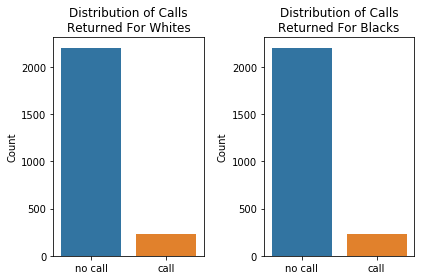

In [134]:
# create bar plots
f, (ax1, ax2) = plt.subplots(1, 2)

# first bar plot: white-sounding names
sns.barplot(x = 'index', y = 'call', data = w_counts_table, ax = ax1)
ax1.set_title('Distribution of Calls\nReturned For white-sounding names')
ax1.set_xticklabels(['no call', 'call'])
ax1.set_xlabel('')
ax1.set_ylabel('Count')

# second bar plot: black-sounding names
sns.barplot(x = 'index', y = 'call', data = w_counts_table, ax = ax2)
ax2.set_title('Distribution of Calls\nReturned For black-sounding names')
ax2.set_xticklabels(['no call', 'call'])
ax2.set_xlabel('')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

Visually, it seems as though there's no significance difference between white-sounding names and black-sounding names.

**Frequentist Approach - Two Sample Z Test**

Procedure:

1. Assume null hypothesis is true. Since $p_{w} = p_{b}$ under the null hypothesis, it means that $p_{w} - p_{b} = 0$.
2. Calculate the test statistic as follows:

$$Z = \frac{\hat{p}_w - \hat{p}_b - 0}{\sqrt{\hat{p}(1 - \hat{p})(\frac{1}{n_w} + \frac{1}{n_b})}}$$

where

$$\hat{p} = \frac{no.\:of\:calls\:returned_w + no.\:of\:calls\:returned_b}{n_w + n_b}$$

3. Calculate the p-value based on the test statistic.
4. Determine whether to reject the null hypothesis or not at 0.05 significance level.
5. Since the alternative hypothesis is $p_w > p_b$, alculate the margin of error and **one-sided** 95% confidence interval. Margin of error is calculated as follows:

$$margin\:of\:error = z_{\alpha}\sqrt{\frac{\hat{p}_w(1 - \hat{p}_w)}{n_w} + \frac{\hat{p}_b(1 - \hat{p}_b)}{n_b}}$$

Confidence interval is calculated as follows:

$$\left(-\infty\:,\:(\hat{p}_w - \hat{p}_b) - margin\:of\:error\right)$$

In [141]:
# observed difference
empirical_diff_proportions = p_w - p_b

# overall proportion of returned calls
p_overall = np.mean(data.call)

# calculate the estimated standard error
se = np.sqrt(p_overall * (1 - p_overall) * (1/n_w + 1/n_b))

# test statistic
z = empirical_diff_proportions / se

# p-value
p_value = norm.sf(z)

print('test statistic: {}, p-value: {}'.format(round(z, 2), p_value))

test statistic: 4.11, p-value: 1.9919441665380294e-05


Based on the p-value, I will reject the null hypothesis at 0.05 significance level. The p-value is very small. The difference between the white-sounding names and the black-sounding names seem to be significant.

In [158]:
# 95% CI using z-distribution
z_statistic = norm.ppf(q = 0.95)
z_statistic
# calculate margin of error
margin_of_error = z_statistic * np.sqrt(p_w * (1 - p_w) / n_w + p_b * (1 - p_b) / n_b)
margin_of_error
# 95% CI
conf_95 = empirical_diff_proportions - margin_of_error
display(Math(r'95\%\:Confidence\:Interval:\:(-\infty, {})'.format(round(conf_95, 4))))

<IPython.core.display.Math object>

**Bootstrap Approach - Test of Proportions**

In [14]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

In [15]:
# bootstrap test of proportions

# Compute mean of all forces: proportion_call
proportion_call = np.mean(data.call)

# Generate shifted arrays
w.call_shifted = w.call - np.mean(w.call) + proportion_call
b.call_shifted = b.call - np.mean(b.call) + proportion_call

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(w.call_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(b.call_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_proportions) / 10000
print('p-value =', p)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


p-value = 0.0001


/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


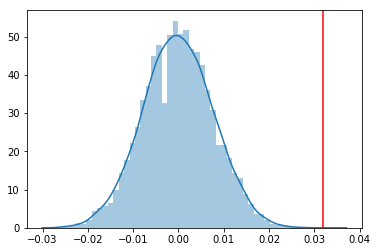

In [16]:
_ = sns.distplot(bs_replicates)
_ = plt.axvline(x=empirical_diff_proportions, color = 'red')
plt.show()

In [17]:
# same distribution? permutation test
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

def permutation_sample(data_1, data_2):
    permuted_data = np.random.permutation(np.concatenate((data_1, data_2)))
    return permuted_data[:len(data_1)], permuted_data[len(data_1):]

def draw_perm_reps(d1, d2, func, size=1):
    return np.array([func(*permutation_sample(d1, d2)) for i in range(size)])


# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(w.call, b.call,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_proportions) / len(perm_replicates)

# Print the result
print('p-value =', p)


p-value = 0.0


/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


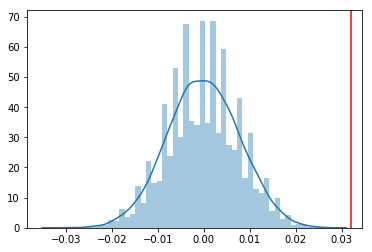

In [18]:
_ = sns.distplot(perm_replicates)
_ = plt.axvline(x=empirical_diff_proportions, color = 'red')
plt.show()

In [19]:
# confidence intervals
# frequentist approach
empirical_diff_proportions + 1.96 * np.array([-sample_se, sample_se]) # doesn't include zero so different

array([0.01677745, 0.04728826])

95% confidence interval = [0.08459959 0.10841889] games


/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


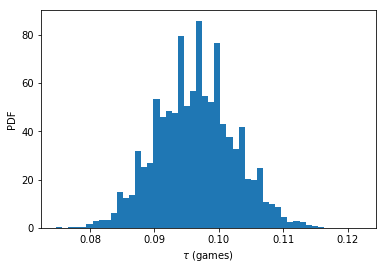

In [20]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(w.call, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, q = [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel(r'$\tau$ (games)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

95% confidence interval = [0.0550308  0.07434291] games


/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


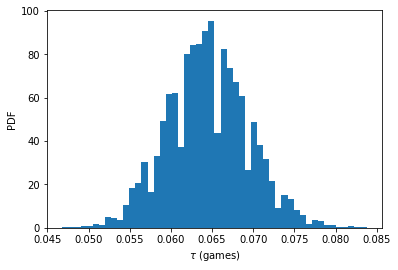

In [21]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(b.call, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, q = [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel(r'$\tau$ (games)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [22]:
# two confidence intervals dont overlap

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

4. Write a story describing the statistical significance in the context or the original problem.
5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

statistically significant. but not the most important factor as there are still other factors involved. like education level and experience level. im not sure how to tweak the experiment to see if this is the most important factor.